# TeamA Machine Learning Project
## Los Angeles Crime Data 2020-Present
### Saulo Guzman and Alex Philipsen

---

Importing Libraries and Data

In [21]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
import numpy as np
import matplotlib.pyplot as plt

In [2]:
uneditedDF = pd.read_csv("Crime_Data_from_2020_to_Present.csv", nrows=100000)

---
## Cleaning Data
We are making use of the features of latitude, longitude, area name, time of day, and crime code.

In [3]:
crimeDF = uneditedDF[['AREA', 'Crm Cd', 'TIME OCC', 'LAT', 'LON']]
print(crimeDF.head(1))

# Splitting data between train, test, and valid sets
trainSet = crimeDF.sample(frac=0.4)
crimeDF = crimeDF.drop(trainSet.index)
testSet = crimeDF.sample(frac=0.3)
crimeDF = crimeDF.drop(testSet.index)
validSet = crimeDF.sample(frac=0.3)
crimeDF = crimeDF.drop(validSet.index)

# Splitting each set into X and y

X_train = trainSet[['AREA', 'TIME OCC', 'LAT', 'LON']]
y_train = trainSet['Crm Cd']
X_test = testSet[['AREA', 'TIME OCC', 'LAT', 'LON']]
y_test = testSet['Crm Cd']
X_valid = validSet[['AREA', 'TIME OCC', 'LAT', 'LON']]
y_valid = validSet['Crm Cd']

Xs = [X_train, X_test, X_valid]

for X in Xs:
    X.loc[X['LAT'] == 0, 'LAT'] = X['LAT'].mean()
    X.loc[X['LON'] == 0, 'LON'] = X['LON'].mean()

   AREA  Crm Cd  TIME OCC      LAT       LON
0     7     510      2130  34.0375 -118.3506


---
## Implementing KNN Classifier

In [4]:
areaCodeToName = (uneditedDF[['AREA', 'AREA NAME']]
                    .drop_duplicates()
                    .sort_values(by='AREA')
                    )

In [5]:
for num_neighbors in range(21):
    knnClassifier = KNeighborsClassifier(n_neighbors=(num_neighbors+1))
    knnClassifier.fit(X_train, y_train)
    y_pred = knnClassifier.predict(X_test)
    print(f"The accuracy for KNN for {num_neighbors+1} on the test set is: {sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)}")

The accuracy for KNN for 1 on the test set is: 0.08661111111111111
The accuracy for KNN for 2 on the test set is: 0.0855
The accuracy for KNN for 3 on the test set is: 0.08583333333333333
The accuracy for KNN for 4 on the test set is: 0.08688888888888889
The accuracy for KNN for 5 on the test set is: 0.08733333333333333
The accuracy for KNN for 6 on the test set is: 0.09044444444444444
The accuracy for KNN for 7 on the test set is: 0.09616666666666666
The accuracy for KNN for 8 on the test set is: 0.10038888888888889
The accuracy for KNN for 9 on the test set is: 0.10255555555555555
The accuracy for KNN for 10 on the test set is: 0.10488888888888889
The accuracy for KNN for 11 on the test set is: 0.10555555555555556
The accuracy for KNN for 12 on the test set is: 0.10466666666666667
The accuracy for KNN for 13 on the test set is: 0.10705555555555556
The accuracy for KNN for 14 on the test set is: 0.10911111111111112
The accuracy for KNN for 15 on the test set is: 0.10916666666666666
Th

The best accuracy achieved for an unwieghted KNN classifier was around 0.11 at num_neighbors = 20. So, next we will try weighting the classifier.

In [6]:
weightedKnn = KNeighborsClassifier(n_neighbors=20, weights='distance')
weightedKnn.fit(X_train, y_train)
weighted_y_pred = weightedKnn.predict(X_test)
print(f"Accuracy for weighted KNN by distance with 20 neighbors: {sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=y_test)}")

Accuracy for weighted KNN by distance with 20 neighbors: 0.11411111111111111


Even with weights, KNN has the same accuracy and is not performing very well. However, this data is not normalized, so we will be testing KNN with normalized data.

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
class NormalizedKNN:
    def __init__(self, X_train, y_train, model):
        self.X = X_train
        self.y = y_train
        self.model = model
        self.scaler = MinMaxScaler()

    def normalizeAndPredict(self, X):

        X_norm = pd.DataFrame(self.scaler.transform(X), columns=X.columns)

        y_pred = self.model.predict(X_norm)

        return y_pred

    def normalizeAndFit(self):
        X_norm = pd.DataFrame(self.scaler.fit_transform(self.X), columns=self.X.columns)

        self.model.fit(X_norm, self.y)

    def getAccuracy(self, X_test, y_test):
        y_pred = self.normalizeAndPredict(X_test)

        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        return accuracy


In [9]:
num_neighbors = 21
model = KNeighborsClassifier(n_neighbors=21)
normalizedKNN = NormalizedKNN(X_train=X_train, y_train=y_train, model=model)

normalizedKNN.normalizeAndFit()
accuracy = normalizedKNN.getAccuracy(X_test=X_test, y_test=y_test)
print(f"Accuracy for a normalized KNN model with 21 neighbors: {accuracy}")

Accuracy for a normalized KNN model with 21 neighbors: 0.10811111111111112


The accuracy of KNN when normalized tends to be around the same as un-normalized.

---
# Predicting the possibility of crime with KNN

For this, we will be using the faker library to generate data where there is no crime at all so that we can distinguish the presence of a crime.

In [ ]:
import random

In [11]:
X_train = trainSet[['AREA', 'TIME OCC', 'LAT', 'LON', 'Crm Cd']]
X_test = testSet[['AREA', 'TIME OCC', 'LAT', 'LON', 'Crm Cd']]
X_valid = validSet[['AREA', 'TIME OCC', 'LAT', 'LON', 'Crm Cd']]

In [12]:
Xs = [X_train, X_test, X_valid]

for X in Xs:
    X.loc[X['LAT'] == 0, 'LAT'] = X['LAT'].mean()
    X.loc[X['LON'] == 0, 'LON'] = X['LON'].mean()

In [13]:
def convert_crime_to_bool(X):
    new_y = pd.DataFrame()
    new_X = X
    new_X["Has Crime"] = new_X['Crm Cd'].apply(lambda x: 0 if x == -1 else 1)

    new_y = new_X['Has Crime']
    new_X = X.drop(columns=['Crm Cd', 'Has Crime'])
    return new_y, new_X

def generate_fake_crime_data(data, num_rows):
    fake_data = pd.DataFrame()
    for column in data.columns:
        if column == 'Crm Cd':
            break
        max_val = data[column].max()
        min_val = data[column].min()
        if(isinstance(max_val, int)):
            fake_data[column] = np.random.choice(range(min_val, max_val), size=num_rows, replace=True)
        else:
            fake_data[column] = [random.uniform(min_val, max_val) for _ in range(num_rows)]
    
    fake_data['Crm Cd'] = [-1 for _ in range(num_rows)]
    new_x = fake_data

    new_x = pd.concat([new_x, data])
    return new_x

In [14]:
new_X_train = generate_fake_crime_data(X_train, X_train.shape[0])
new_y_train, new_X_train = convert_crime_to_bool(new_X_train)

new_X_test = generate_fake_crime_data(X_test, X_test.shape[0])
new_y_test, new_X_test = convert_crime_to_bool(new_X_test)

new_X_valid = generate_fake_crime_data(X_valid, X_valid.shape[0])
new_y_valid, new_X_valid = convert_crime_to_bool(new_X_valid)

In [15]:
for num_neighbors in range(21):
    knnClassifier = KNeighborsClassifier(n_neighbors=(num_neighbors+1))
    knnClassifier.fit(new_X_train, new_y_train)
    y_pred = knnClassifier.predict(new_X_test)
    print(f"The accuracy for KNN for {num_neighbors+1} on the test set is: {sklearn.metrics.accuracy_score(y_pred=y_pred, y_true=new_y_test)}")

The accuracy for KNN for 1 on the test set is: 0.8870555555555556
The accuracy for KNN for 2 on the test set is: 0.8939722222222222
The accuracy for KNN for 3 on the test set is: 0.8697777777777778
The accuracy for KNN for 4 on the test set is: 0.8756944444444444
The accuracy for KNN for 5 on the test set is: 0.8595833333333334
The accuracy for KNN for 6 on the test set is: 0.8619166666666667
The accuracy for KNN for 7 on the test set is: 0.8512222222222222
The accuracy for KNN for 8 on the test set is: 0.8533611111111111
The accuracy for KNN for 9 on the test set is: 0.8428055555555556
The accuracy for KNN for 10 on the test set is: 0.8436388888888889
The accuracy for KNN for 11 on the test set is: 0.8348055555555556
The accuracy for KNN for 12 on the test set is: 0.8380277777777778
The accuracy for KNN for 13 on the test set is: 0.8284444444444444
The accuracy for KNN for 14 on the test set is: 0.8302777777777778
The accuracy for KNN for 15 on the test set is: 0.82375
The accuracy fo

The highest accuracy in determining the presence of a crime is 0.89 with 2 neighbors.

In [19]:
# This Function is taken from HW1 helpers
def display_confusion(c_matrix):
    """
    Displays the confusion matrix using matrix show
    Args:
        c_matrix: square confusion matrix, shape (num_classes, num_classes)
    """
    _, ax = plt.subplots()
    ax.matshow(c_matrix, cmap=plt.cm.Blues)
    for i in range(c_matrix.shape[0]):
        for j in range(c_matrix.shape[0]):
            ax.text(i, j, str(c_matrix[j, i]), va='center', ha='center')
    plt.show()

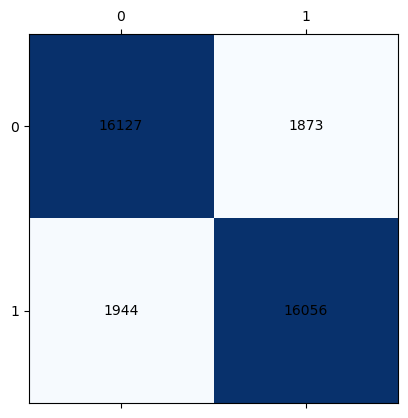

In [22]:
from sklearn.metrics import confusion_matrix

knnClassifier = KNeighborsClassifier(2)
knnClassifier.fit(new_X_train, new_y_train)
y_pred = knnClassifier.predict(new_X_test)
cm = confusion_matrix(y_pred=y_pred, y_true=new_y_test)
display_confusion(cm)